In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
# cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

/Users/theoares/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [2]:
# ens = '24I/ml0p005/'
# # ens = '24I/ml0p01/'
# L = Lattice(24, 64)
# ainv = 1.784
# a = hbarc / ainv

# file_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/' + ens + 'Z_gamma.h5'
# f = h5py.File(file_path, 'r')
# moms = f['momenta'][()]
# mu_list = np.array([get_energy_scale(q, a, L) for q in moms])
# Zq = np.real(f['Zq'][()])
# n_momenta, n_boot = Zq.shape
# ZV = np.real(f['ZV'][()])
# ZA = np.real(f['ZA'][()])
# Z = np.zeros((5, 5, n_momenta, n_boot), dtype = np.float64)
# for i, j in itertools.product(range(5), repeat = 2):
#     key = 'Z' + str(i + 1) + str(j + 1)
#     Z[i, j] = np.real(f[key][()])

In [3]:
ensembles = ['24I/ml0p005/', '24I/ml0p01/', '32I/ml0p004/', '32I/ml0p006/']
Lats = [Lattice(24, 64), Lattice(24, 64), Lattice(32, 64), Lattice(32, 64)]
ainv_list = [1.784, 1.784, 2.382, 2.382]    # GeV
mpi_list = [0.3396, 0.4322, 0.3020, 0.3597]    # GeV
a_list = [hbarc / ainv for ainv in ainv_list]
n_ens = len(ensembles)
ampi_list = [mpi_list[i] / ainv_list[i] for i in range(n_ens)]

colors = ['r', 'b', 'c', 'g']

file_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/' + ens + 'Z_gamma.h5' for ens in ensembles]
Fs = [h5py.File(fpath, 'r') for fpath in file_paths]
k_list = [f['momenta'][()] for f in Fs]
mom_list = [[Lats[i].to_linear_momentum(k, datatype=np.float64) for k in k_list[i]] for i in range(n_ens)]
mu_list = [np.array([get_energy_scale(q, a_list[i], Lats[i]) for q in k_list[i]]) for i in range(n_ens)]
Zq_list = [np.real(f['Zq'][()]) for f in Fs]
n_momenta, n_boot = [Zq.shape[0] for Zq in Zq_list], [Zq.shape[1] for Zq in Zq_list]
ZV_list = [np.real(f['ZV'][()]) for f in Fs]
ZA_list = [np.real(f['ZA'][()]) for f in Fs]
Z_list = []
for idx in range(n_ens):
    Z = np.zeros((5, 5, n_momenta[idx], n_boot[idx]), dtype = np.float64)
    f = Fs[idx]
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        Z[i, j] = np.real(f[key][()])
    Z_list.append(Z)

In [20]:
# read out chiral extrap data
n_spacings = 2
n_ens_sp = 2    # 2 ensembles per lattice spacing
n_mom = n_momenta[0]
Lat_24I = Lattice(24, 64)
Lat_32I = Lattice(32, 64)
Z_extrap = np.zeros((n_spacings, 5, 5, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
Z_extrap_mu = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)          # [24I/32I, i, j, q_idx]
Z_extrap_sigma = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)
chi_extrap_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap.h5', \
                    '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap.h5']
for idx in range(2):
    f = h5py.File(chi_extrap_paths[idx], 'r')
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        try:
            Z_extrap[idx, i, j] = np.real(f[key][()])
        except:
            print('no key at ' + key)
for sp_idx in range(n_spacings):
    for i, j in itertools.product(range(5), repeat = 2):
        for mom_idx in range(n_mom):
            Z_tmp = Superboot(n_ens_sp)
            Z_tmp.boots = Z_extrap[sp_idx, i, j, mom_idx]
            Z_extrap_mu[sp_idx, i, j, mom_idx] = Z_tmp.compute_mean()
            Z_extrap_sigma[sp_idx, i, j, mom_idx] = Z_tmp.compute_std()
stagger = 1e-5    # offsets the chiral extrap from the original data so you can see the errorbar difference
k_list_chiral = f['momenta'][()]
mom_list_24I = [Lat_24I.to_linear_momentum(k, datatype = np.float64) for k in k_list_chiral]
mom_list_32I = [Lat_32I.to_linear_momentum(k, datatype = np.float64) for k in k_list_chiral]

no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53
no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53


<IPython.core.display.Javascript object>


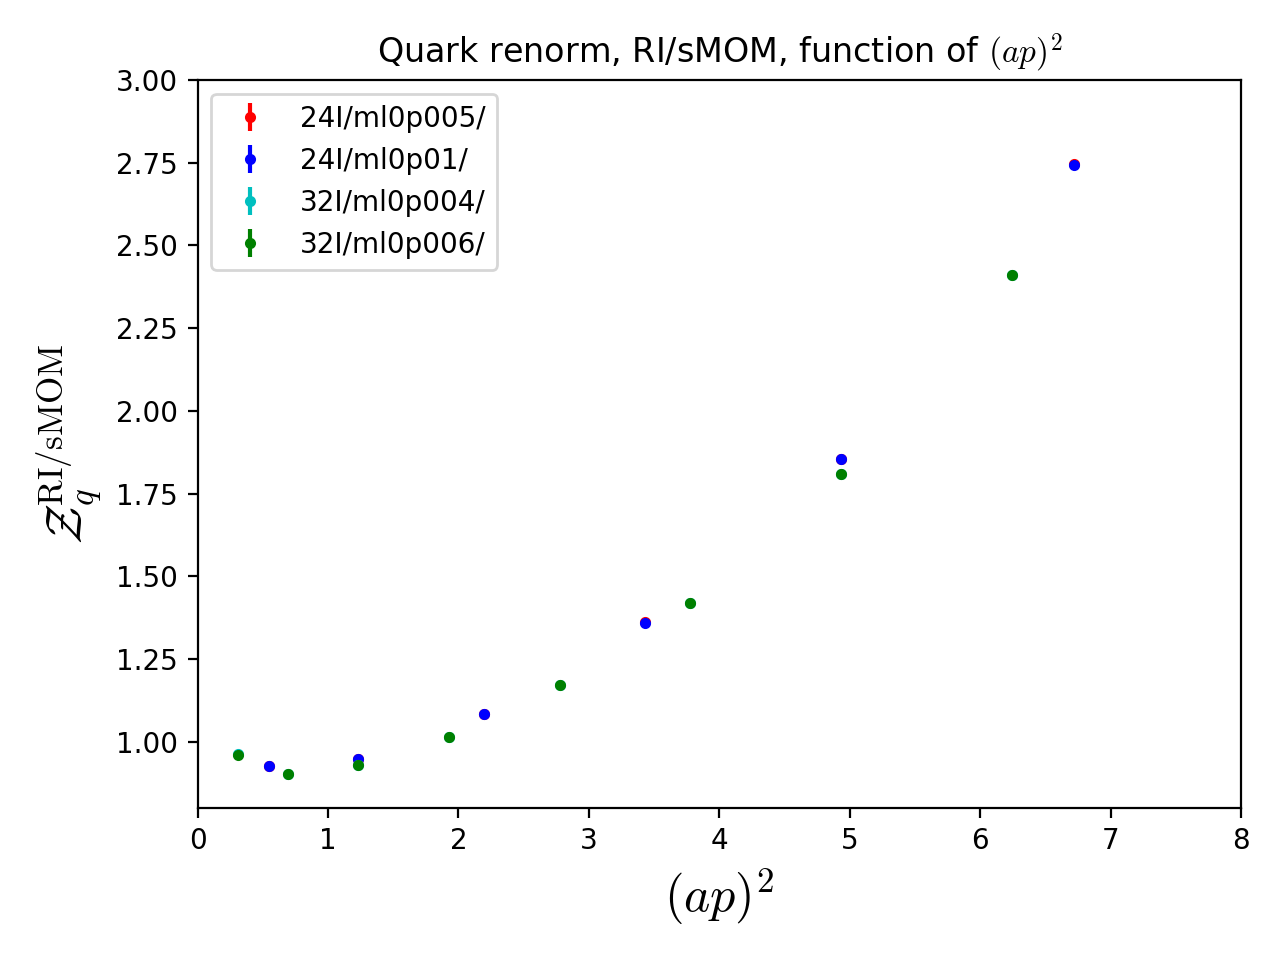

In [5]:
# Zq((ap)^2)
Zq_mu_list = [np.mean(Zq, axis = 1) for Zq in Zq_list]
Zq_sigma_list = [np.std(Zq, axis = 1, ddof = 1) for Zq in Zq_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Zq_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.ylim((0.8, 3))
plt.xlim((0, 8))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Quark renorm, RI/sMOM, function of $(ap)^2$')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


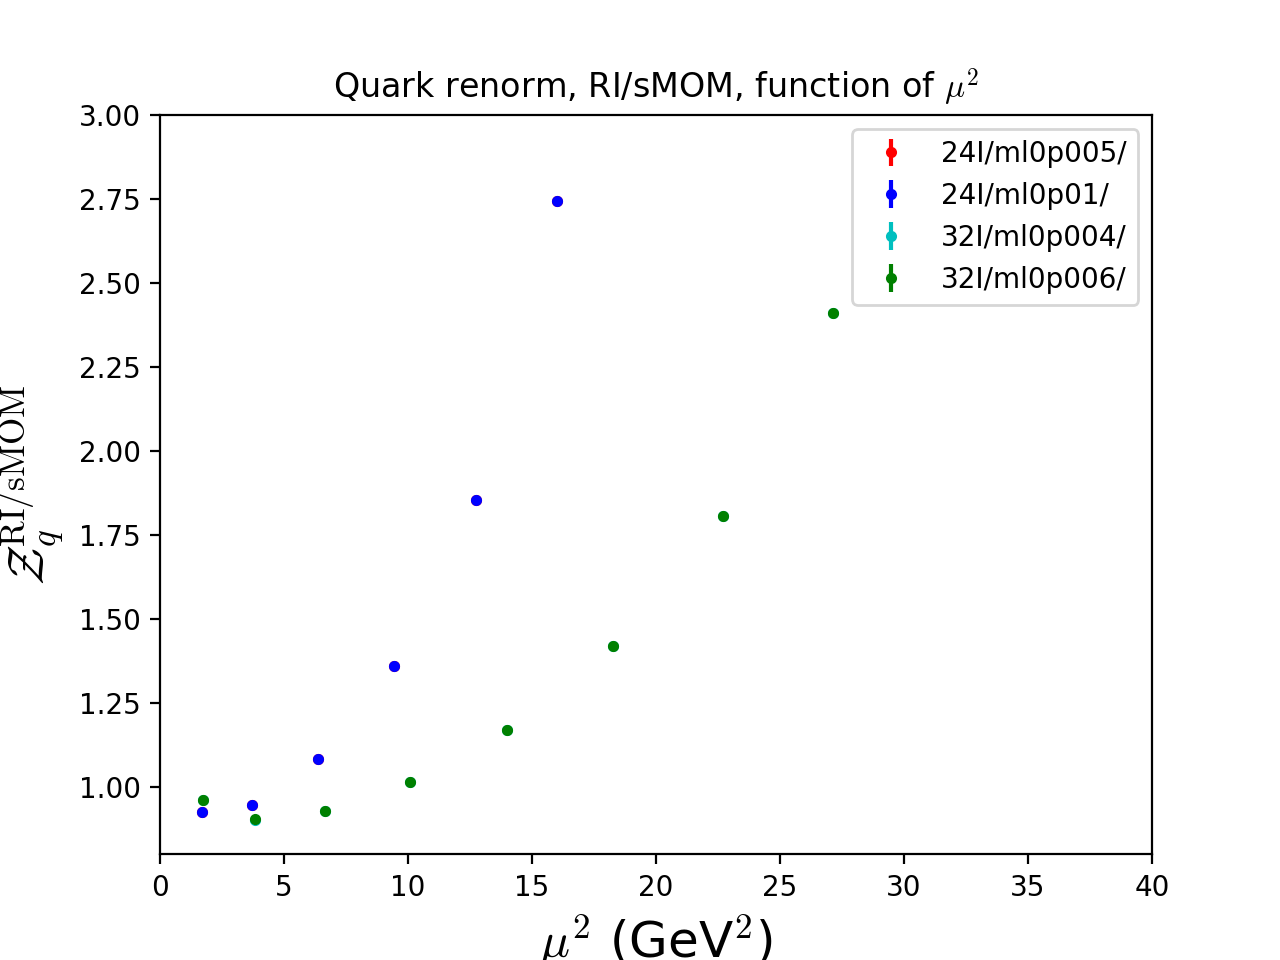

In [6]:
# Zq (μ^2)
plt.figure()
for idx in range(n_ens):
    plt.errorbar([mu ** 2 for mu in mu_list[idx]], Zq_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.ylim((0.8, 3))
plt.xlim((0, 40))
plt.xlabel('$\mu^2$ (GeV$^2$)', fontsize = 18)
plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Quark renorm, RI/sMOM, function of $\mu^2$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


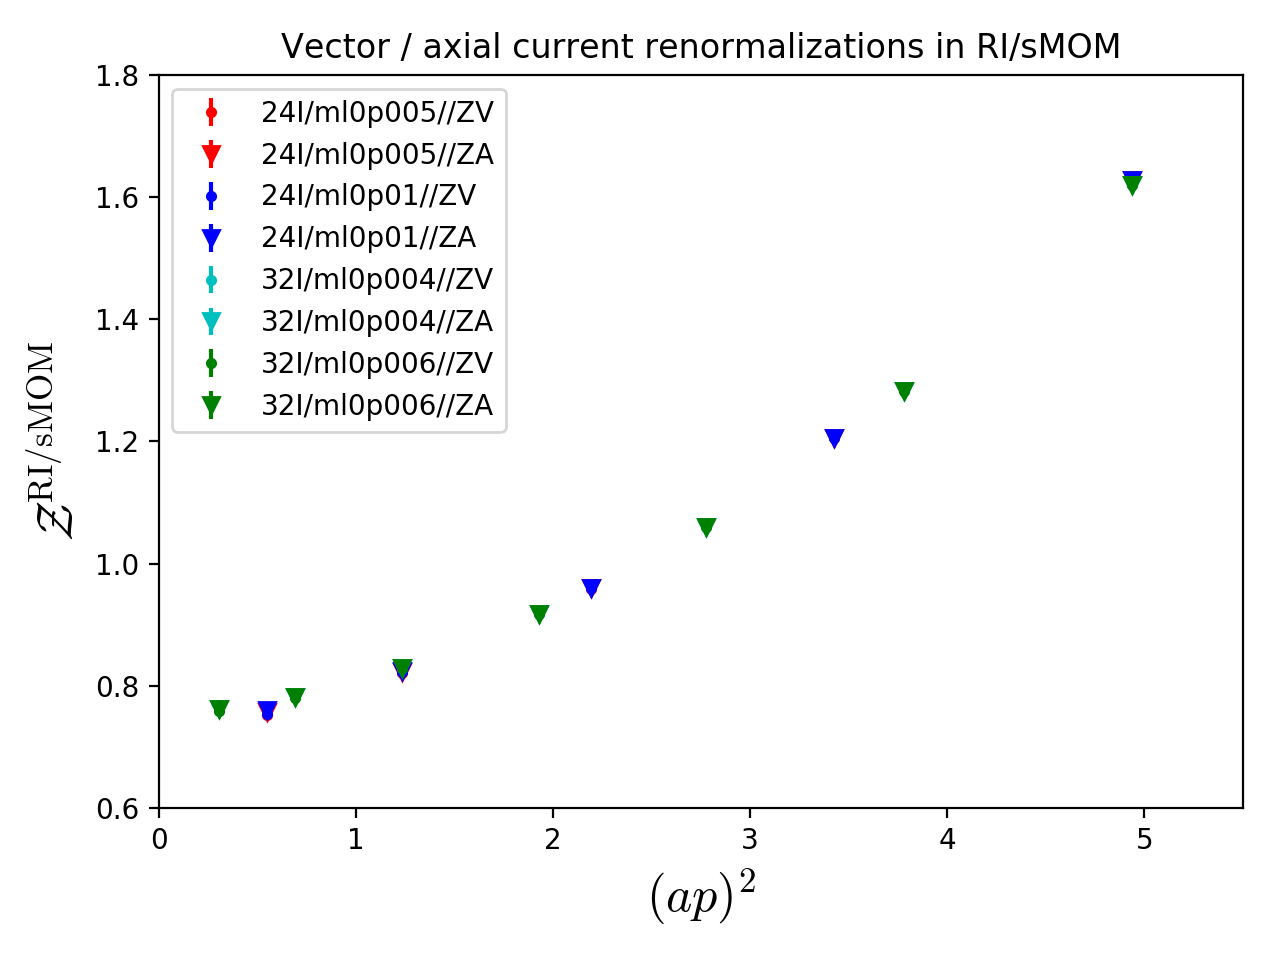

In [7]:
# ZV and ZA
ZV_mu_list = [np.mean(ZV, axis = 1) for ZV in ZV_list]
ZV_sigma_list = [np.std(ZV, axis = 1, ddof = 1) for ZV in ZV_list]
ZA_mu_list = [np.mean(ZA, axis = 1) for ZA in ZA_list]
ZA_sigma_list = [np.std(ZA, axis = 1, ddof = 1) for ZA in ZA_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], ZV_mu_list[idx], ZV_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + '/ZV')
    plt.errorbar([square(k) for k in mom_list[idx]], ZA_mu_list[idx], ZA_sigma_list[idx], fmt = 'v', c = colors[idx], label = ensembles[idx] + '/ZA')
#     plt.errorbar(mu_list[idx] ** 2, ZV_mu_list[idx], ZV_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + '/ZV')
#     plt.errorbar(mu_list[idx] ** 2, ZA_mu_list[idx], ZA_sigma_list[idx], fmt = 'v', c = colors[idx], label = ensembles[idx] + '/ZA')
plt.ylim((0.6, 1.8))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Vector / axial current renormalizations in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


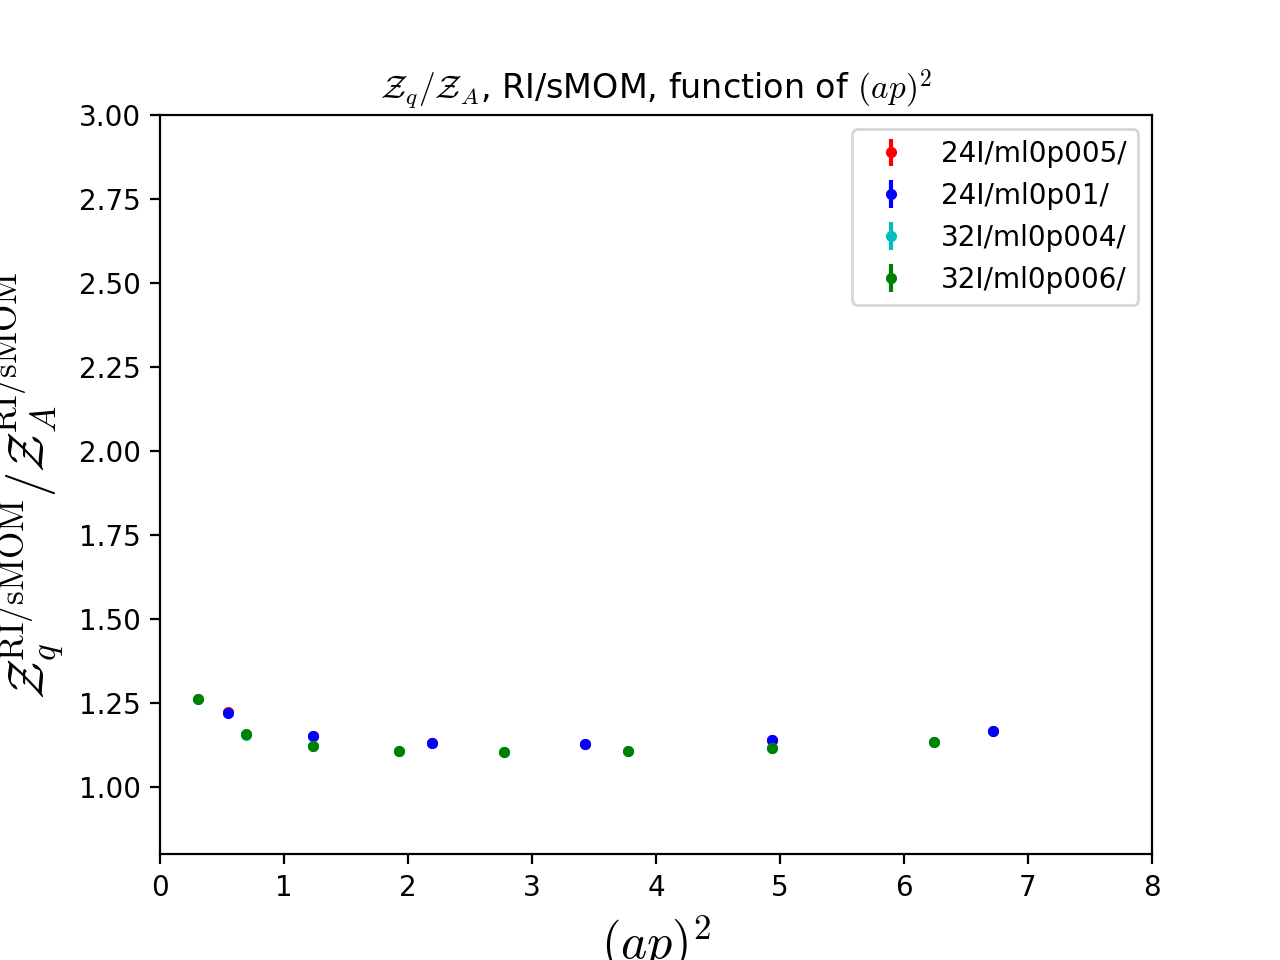

In [8]:
# Zq / ZA
Zq_mu_list = [np.mean(Zq, axis = 1) for Zq in Zq_list]
Zq_sigma_list = [np.std(Zq, axis = 1, ddof = 1) for Zq in Zq_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Zq_mu_list[idx] / ZA_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.ylim((0.8, 3))
plt.xlim((0, 8))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM} / \mathcal{Z}_A^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$\mathcal{Z}_q / \mathcal{Z}_A$, RI/sMOM, function of $(ap)^2$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


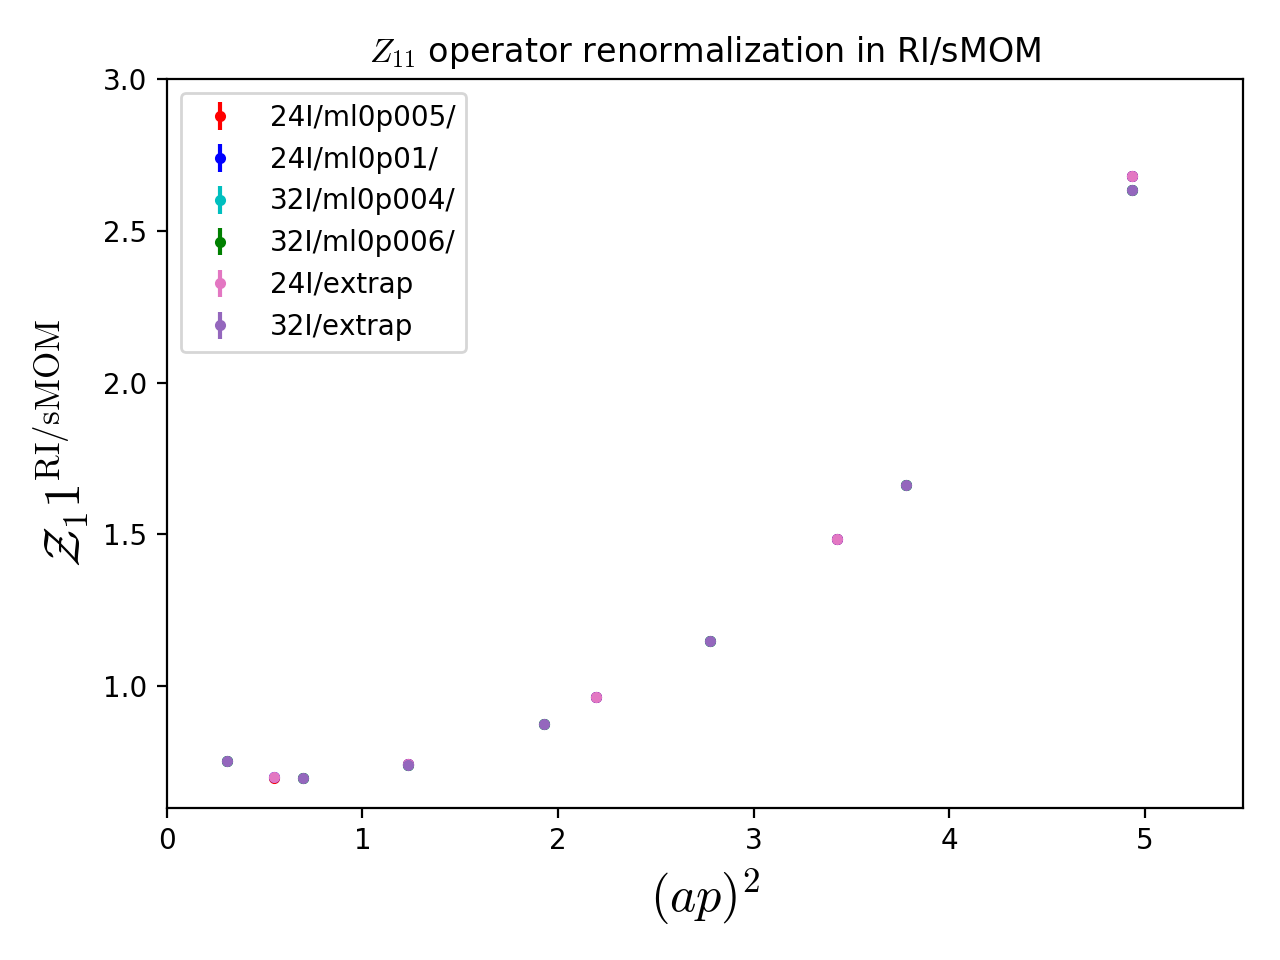

In [21]:
# Z11
Z11_mu_list = [np.mean(Z[0, 0], axis = 1) for Z in Z_list]
Z11_sigma_list = [np.std(Z[0, 0], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z11_mu_list[idx], Z11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 0, 0], Z_extrap_sigma[0, 0, 0], fmt = '.', c = 'tab:pink', label = '24I/extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 0, 0], Z_extrap_sigma[1, 0, 0], fmt = '.', c = 'tab:purple', label = '32I/extrap')
plt.ylim((0.6, 3))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}_11^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{11}$ operator renormalization in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


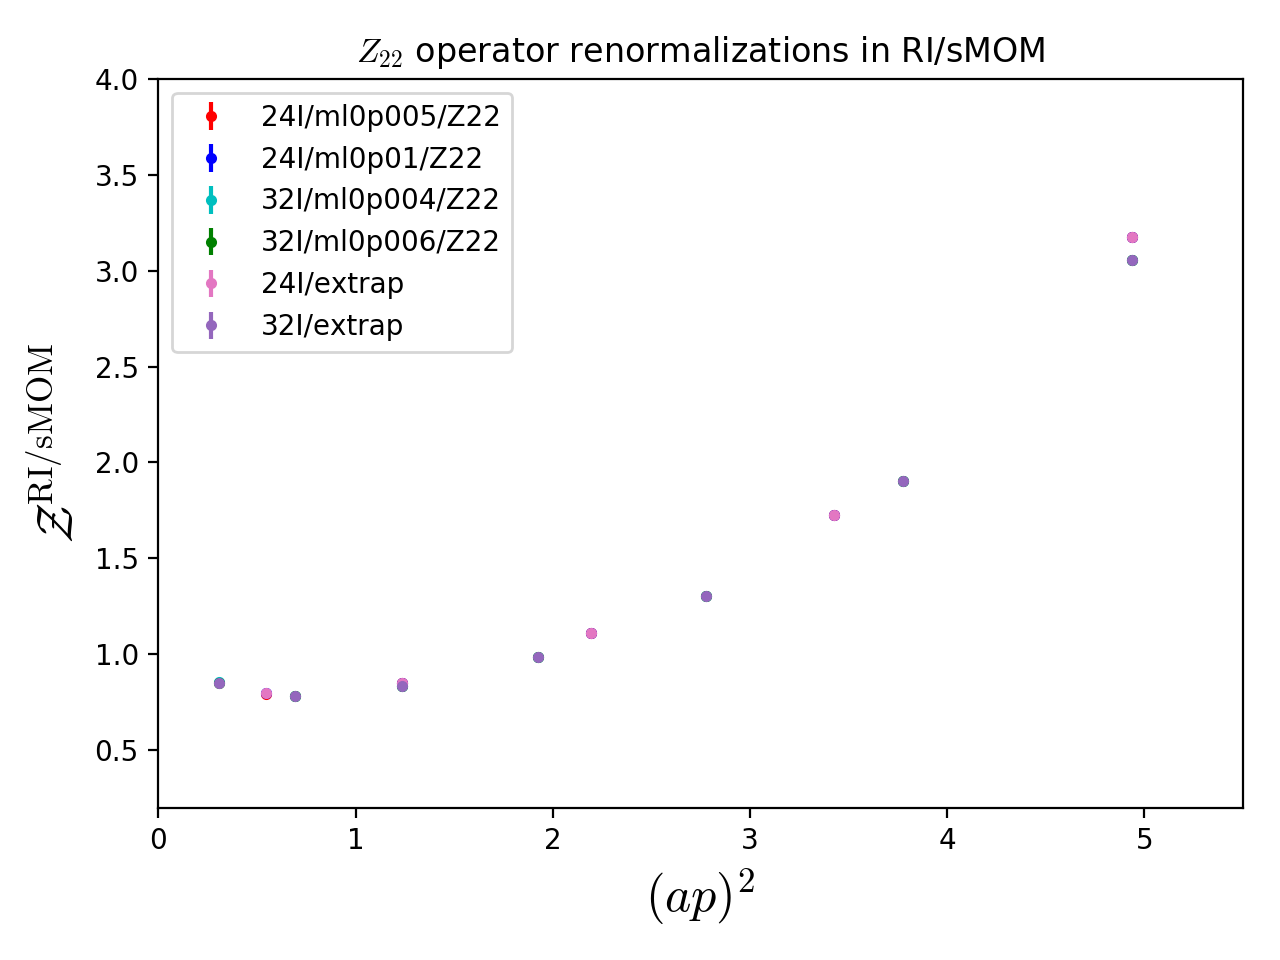

In [22]:
# Z22
Z22_mu_list = [np.mean(Z[1, 1], axis = 1) for Z in Z_list]
Z22_sigma_list = [np.std(Z[1, 1], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z22_mu_list[idx], Z22_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z22')
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 1], Z_extrap_sigma[0, 1, 1], fmt = '.', c = 'tab:pink', label = '24I/extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 1], Z_extrap_sigma[1, 1, 1], fmt = '.', c = 'tab:purple', label = '32I/extrap')
plt.ylim((0.2, 4))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{22}$ operator renormalizations in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


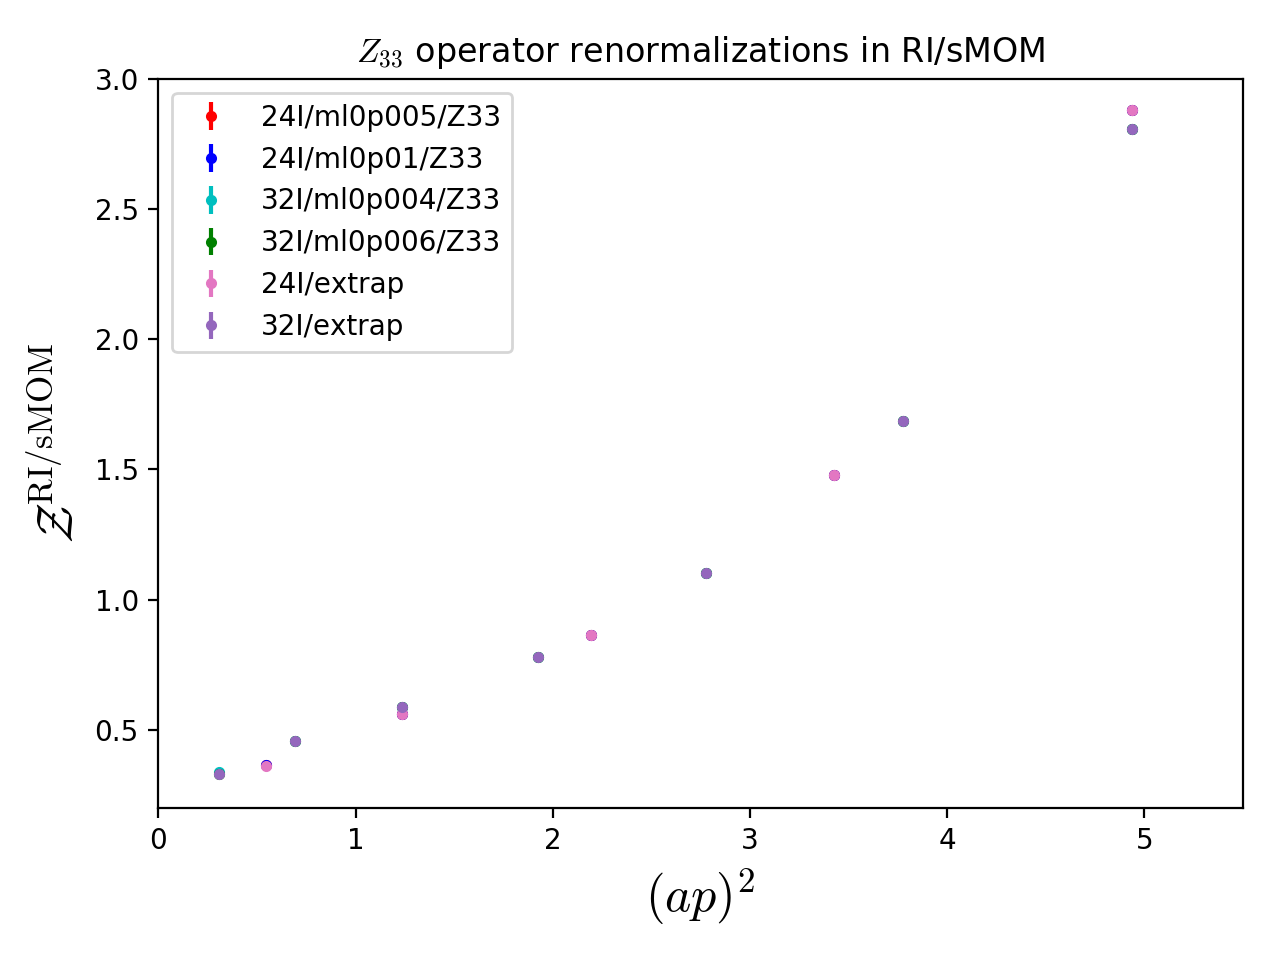

In [23]:
# Z33 
Z33_mu_list = [np.mean(Z[2, 2], axis = 1) for Z in Z_list]
Z33_sigma_list = [np.std(Z[2, 2], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z33_mu_list[idx], Z33_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z33')
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 2, 2], Z_extrap_sigma[0, 2, 2], fmt = '.', c = 'tab:pink', label = '24I/extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 2, 2], Z_extrap_sigma[1, 2, 2], fmt = '.', c = 'tab:purple', label = '32I/extrap')
plt.ylim((0.2, 3))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{33}$ operator renormalizations in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


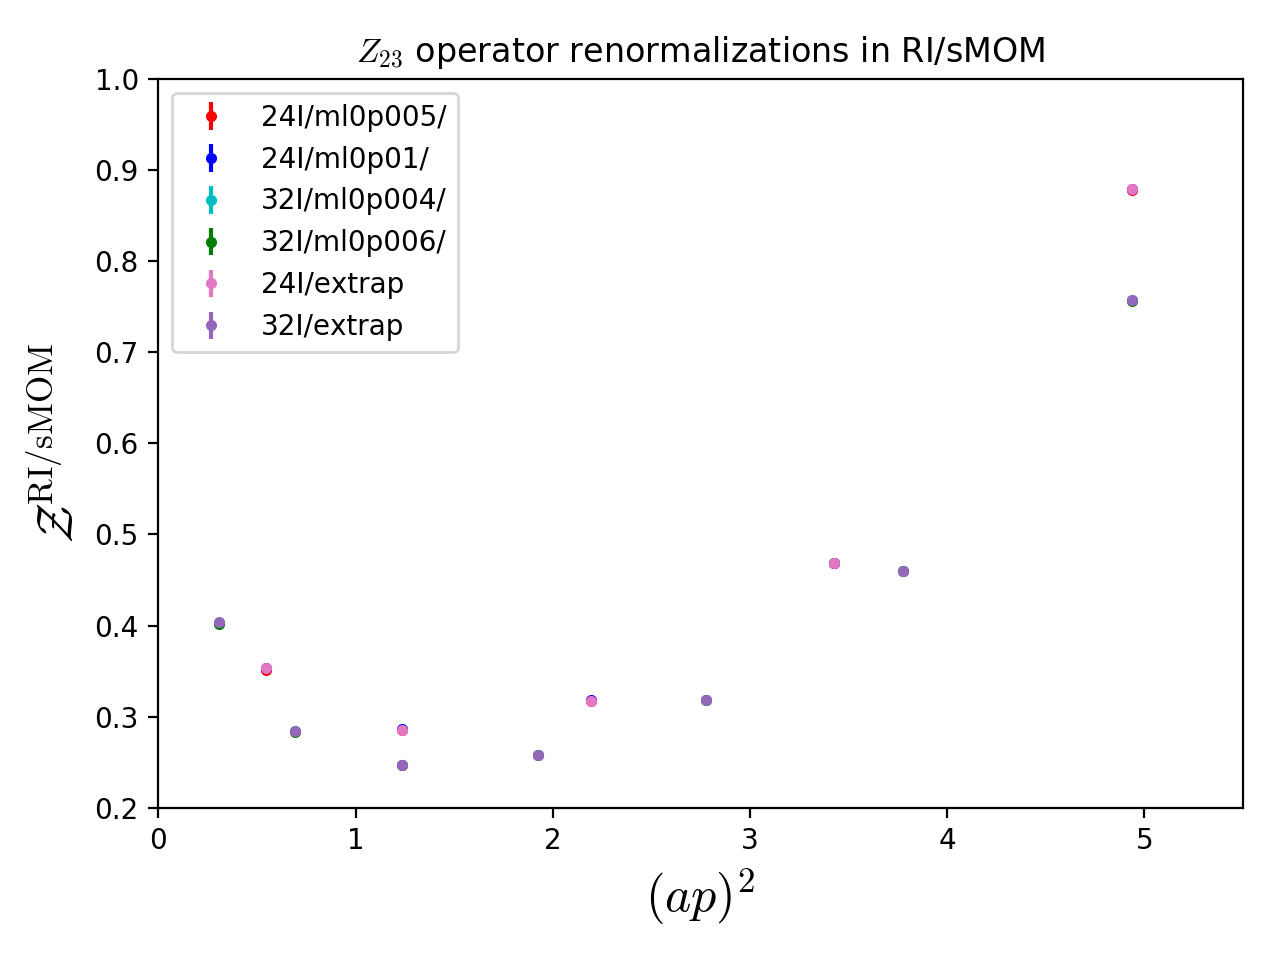

In [24]:
# Z23
Z23_mu_list = [np.mean(Z[1, 2], axis = 1) for Z in Z_list]
Z23_sigma_list = [np.std(Z[1, 2], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z23_mu_list[idx], Z23_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 2], Z_extrap_sigma[0, 1, 2], fmt = '.', c = 'tab:pink', label = '24I/extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 2], Z_extrap_sigma[1, 1, 2], fmt = '.', c = 'tab:purple', label = '32I/extrap')
plt.ylim((0.2, 1))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{23}$ operator renormalizations in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


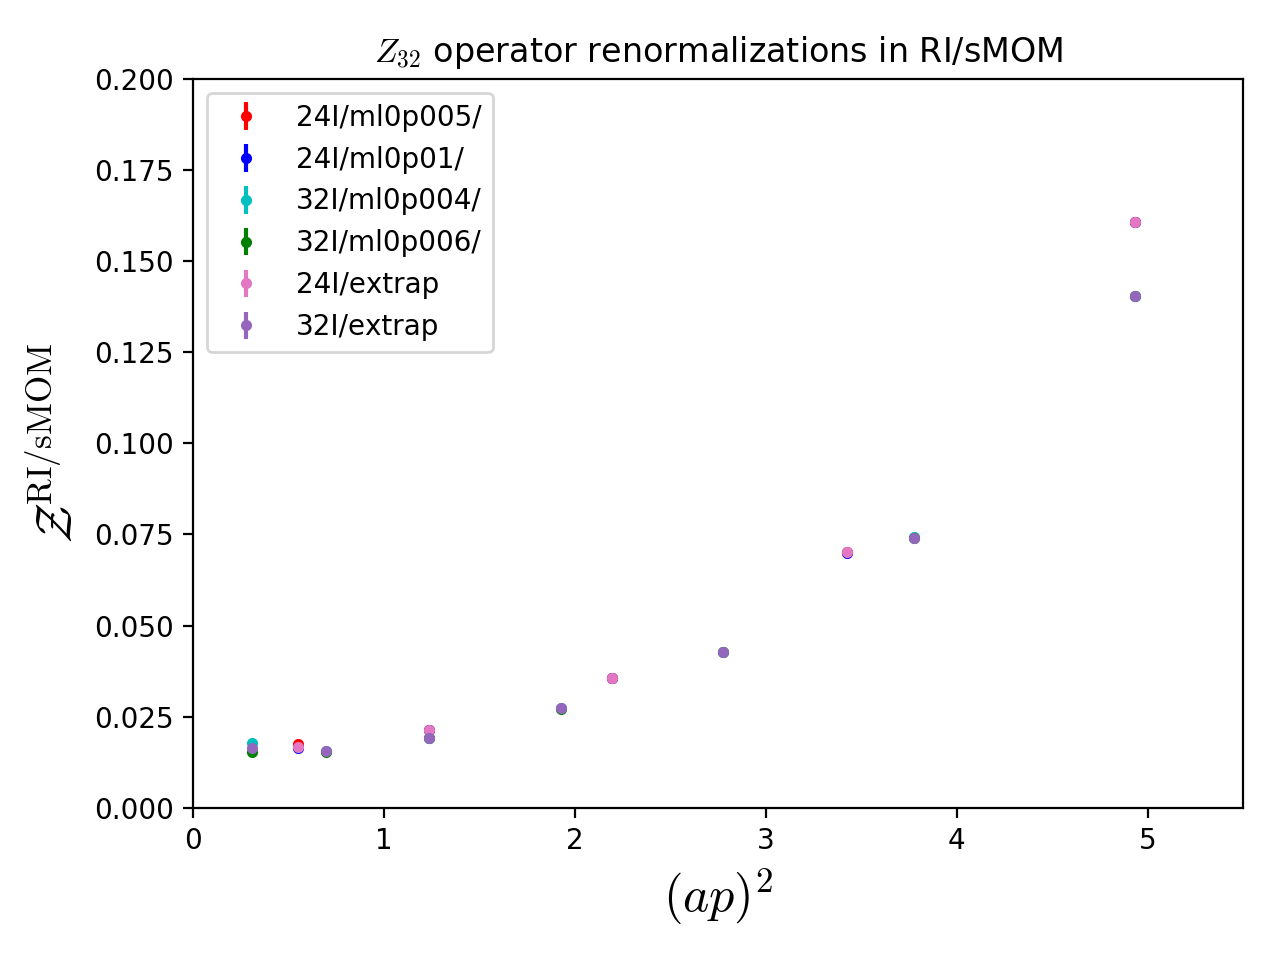

In [25]:
# Z32
Z32_mu_list = [np.mean(Z[2, 1], axis = 1) for Z in Z_list]
Z32_sigma_list = [np.std(Z[2, 1], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z32_mu_list[idx], Z32_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 2, 1], Z_extrap_sigma[0, 2, 1], fmt = '.', c = 'tab:pink', label = '24I/extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 2, 1], Z_extrap_sigma[1, 2, 1], fmt = '.', c = 'tab:purple', label = '32I/extrap')
plt.ylim((0, 0.2))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{32}$ operator renormalizations in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


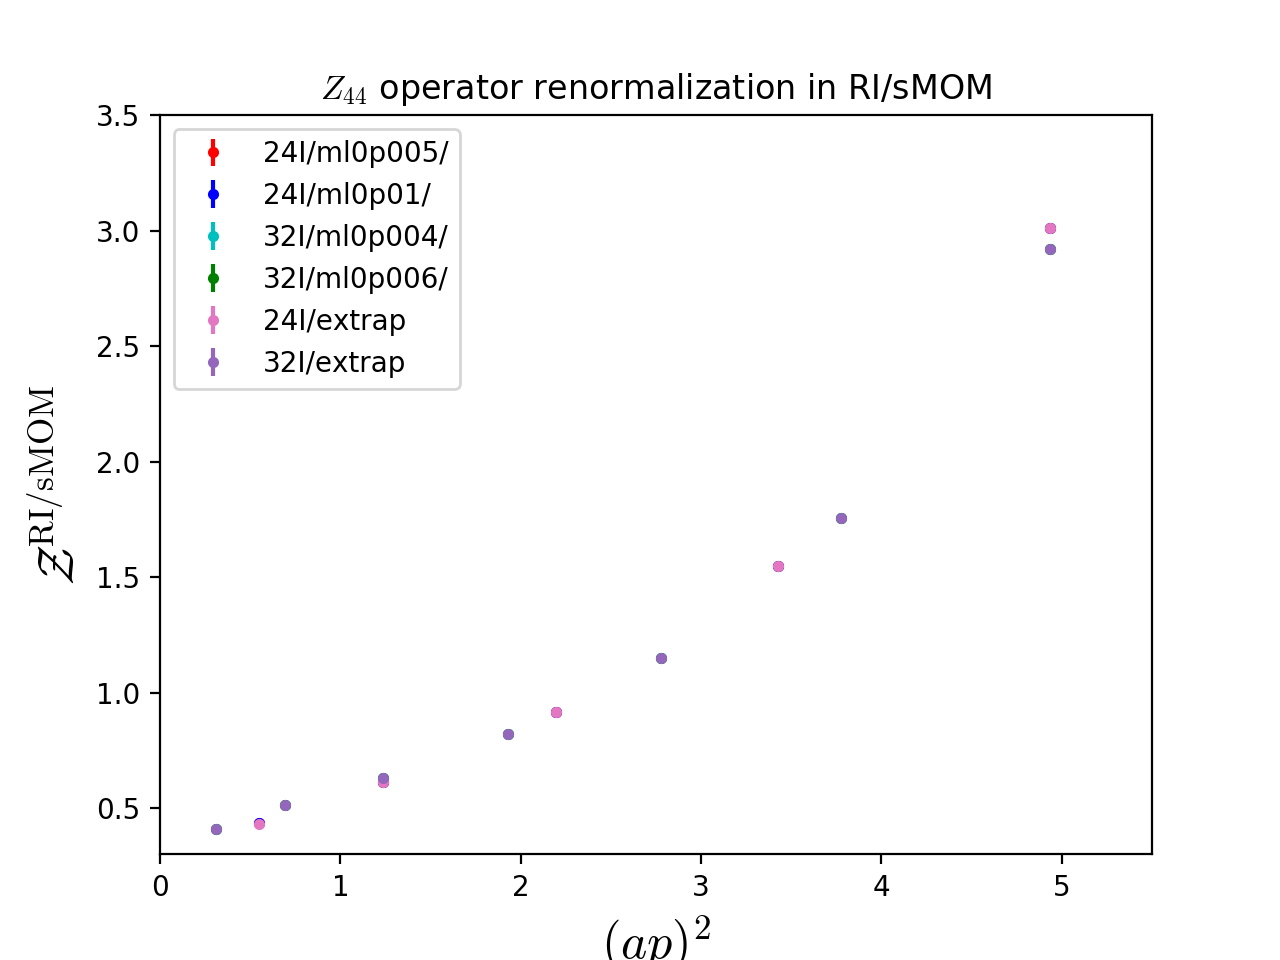

In [26]:
# Z44
Z44_mu_list = [np.mean(Z[3, 3], axis = 1) for Z in Z_list]
Z44_sigma_list = [np.std(Z[3, 3], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z44_mu_list[idx], Z44_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 3, 3], Z_extrap_sigma[0, 3, 3], fmt = '.', c = 'tab:pink', label = '24I/extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 3, 3], Z_extrap_sigma[1, 3, 3], fmt = '.', c = 'tab:purple', label = '32I/extrap')
plt.ylim((0.3, 3.5))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{44}$ operator renormalization in RI/sMOM')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


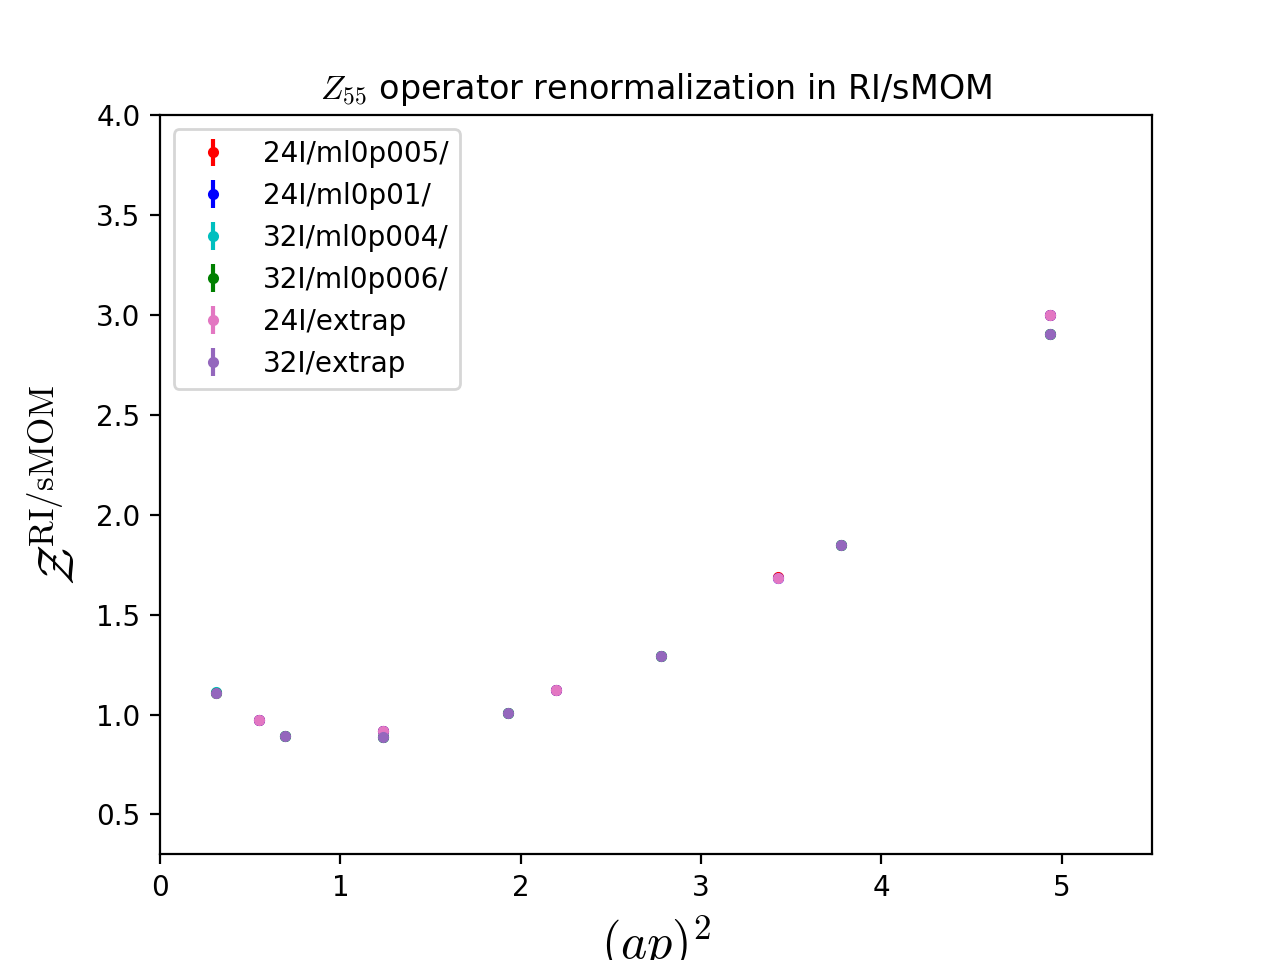

In [27]:
# Z55
Z55_mu_list = [np.mean(Z[4, 4], axis = 1) for Z in Z_list]
Z55_sigma_list = [np.std(Z[4, 4], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z55_mu_list[idx], Z55_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 4, 4], Z_extrap_sigma[0, 4, 4], fmt = '.', c = 'tab:pink', label = '24I/extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 4, 4], Z_extrap_sigma[1, 4, 4], fmt = '.', c = 'tab:purple', label = '32I/extrap')
plt.ylim((0.3, 4.0))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{55}$ operator renormalization in RI/sMOM')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


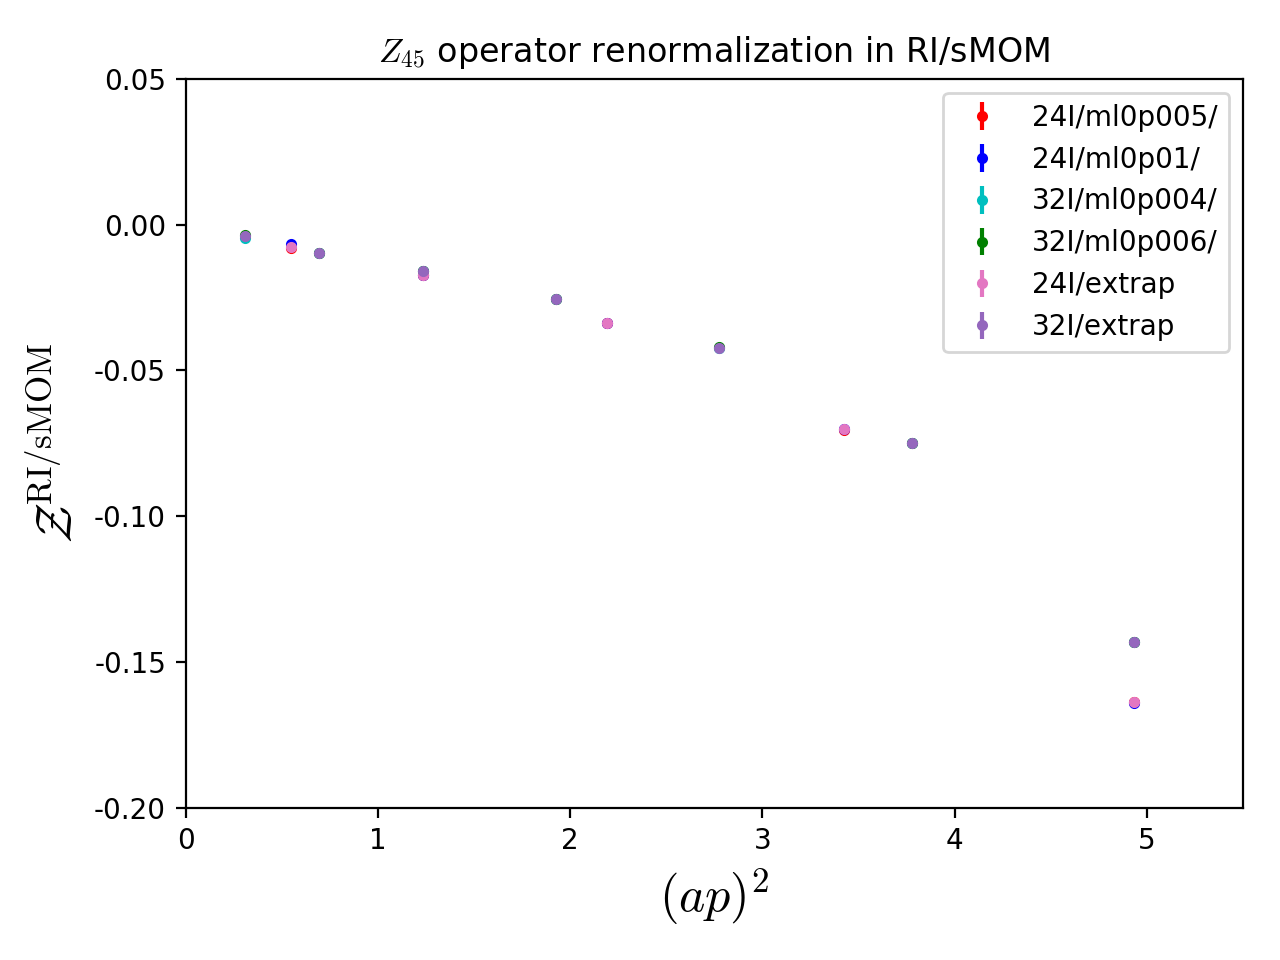

In [28]:
# Z45
Z45_mu_list = [np.mean(Z[3, 4], axis = 1) for Z in Z_list]
Z45_sigma_list = [np.std(Z[3, 4], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z45_mu_list[idx], Z45_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 3, 4], Z_extrap_sigma[0, 3, 4], fmt = '.', c = 'tab:pink', label = '24I/extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 3, 4], Z_extrap_sigma[1, 3, 4], fmt = '.', c = 'tab:purple', label = '32I/extrap')
plt.ylim((-0.2, 0.05))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{45}$ operator renormalization in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


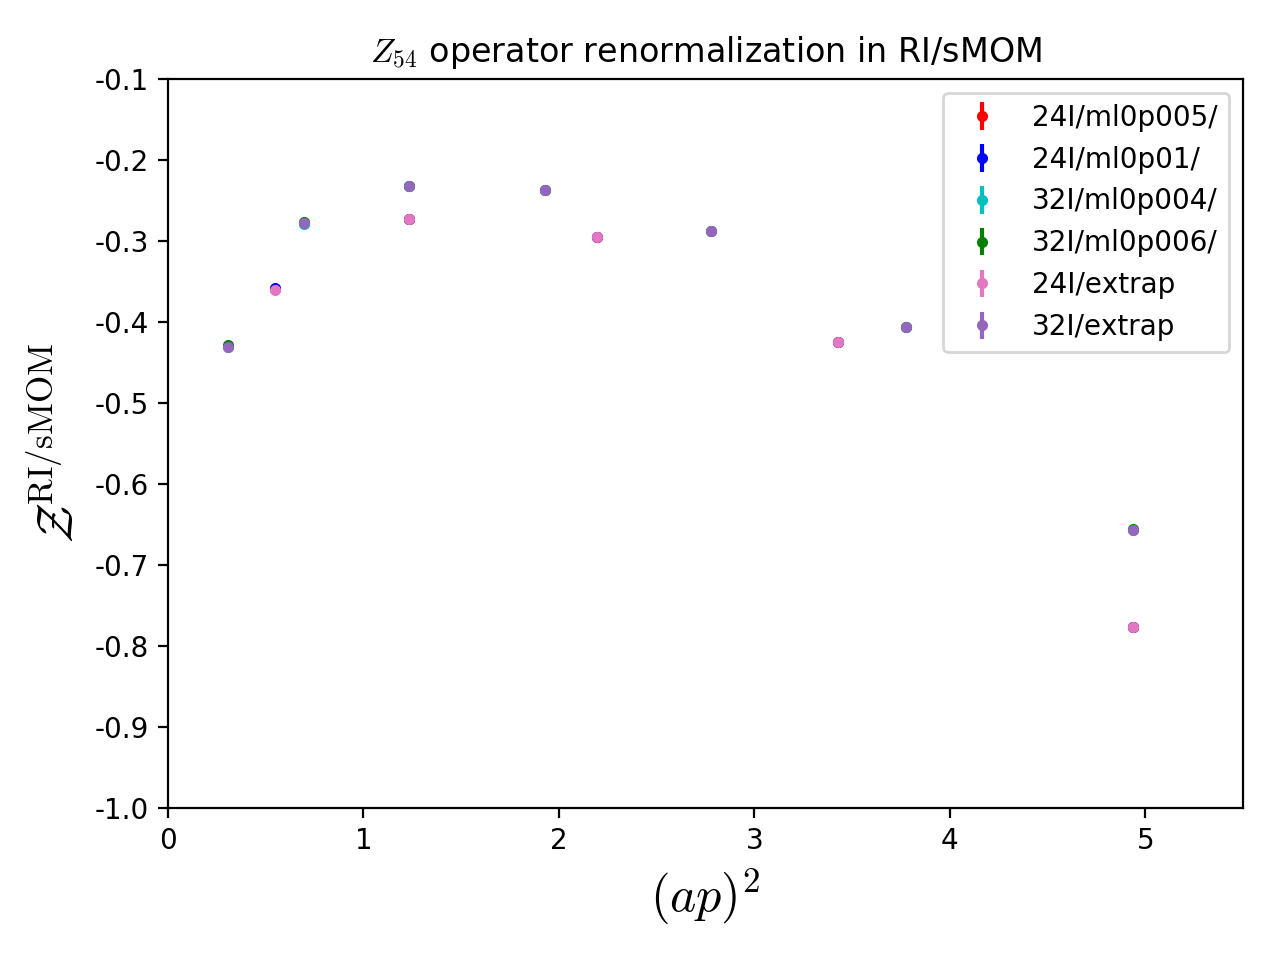

In [29]:
# Z54
Z54_mu_list = [np.mean(Z[4, 3], axis = 1) for Z in Z_list]
Z54_sigma_list = [np.std(Z[4, 3], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z54_mu_list[idx], Z54_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 4, 3], Z_extrap_sigma[0, 4, 3], fmt = '.', c = 'tab:pink', label = '24I/extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 4, 3], Z_extrap_sigma[1, 4, 3], fmt = '.', c = 'tab:purple', label = '32I/extrap')
plt.ylim((-1, -0.1))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{54}$ operator renormalization in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

## Scale evolution of different RCs